# SVM Modeling
- Ignoring data before 2006.
- Using only type=5 examples.
- No feature selection.
- Param tuning.
- Added back removed features ['Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4'].
- Removed soil_data features.
- Shift features for 6 months before.
- One hot encoding for some features.

In [25]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear

sns.set(style="whitegrid")

In [27]:
from fastai.structured import *
from fastai.column_data import *

## Train and test datasets

Basic data containing palm tree information

In [28]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
# df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
# df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False).reindex()

# Configure number of jobs.
N_JOBS=7

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

Shapes
---
Train: (5243, 7)
 Test: (4110, 6)
  All: (9353, 7)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [29]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=6, shiftFtrs=['temperature', 'dewpoint', 'windspeed', 
                                                                 'Precipitation', 'Soilwater_L1', 
                                                                 'Soilwater_L2', 'Soilwater_L3', 
                                                                 'Soilwater_L4'])
#df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month', 'production', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4', 'Soilwater_L1_5', 'Soilwater_L2_1', 'Soilwater_L2_2', 'Soilwater_L2_3', 'Soilwater_L2_4', 'Soilwater_L2_5', 'Soilwater_L3_1', 'Soilwater_L3_2', 'Soilwater_L3_3', 'Soilwater_L3_4', 'Soilwater_L3_5', 'Soilwater_L4_1', 'Soilwater_L4_2', 'Soilwater_L4_3', 'Soilwater_L4_4', 'Soilwater_L4_5']


In [30]:
df_all_ftrs.head()

,index,Id,field,age,type,harvest_year,harvest_month,production,temperature,dewpoint,...,Soilwater_L3_1,Soilwater_L3_2,Soilwater_L3_3,Soilwater_L3_4,Soilwater_L3_5,Soilwater_L4_1,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5
0,0,0,0,19,5,2004,1,0.064071,26.132,24.661,...,0.310656,0.310656,0.310656,0.310656,0.310656,0.314165,0.314165,0.314165,0.314165,0.314165
1,1,1532,0,13,2,2004,1,0.283228,26.132,24.661,...,0.310656,0.310656,0.310656,0.310656,0.310656,0.314165,0.314165,0.314165,0.314165,0.314165
2,2,4204,0,4,5,2004,1,0.106263,26.132,24.661,...,0.310656,0.310656,0.310656,0.310656,0.310656,0.314165,0.314165,0.314165,0.314165,0.314165
3,3,1,0,19,5,2004,2,0.047658,25.295,24.401,...,0.348440,0.310656,0.310656,0.310656,0.310656,0.333850,0.314165,0.314165,0.314165,0.314165
4,4,1533,0,13,2,2004,2,0.182068,25.295,24.401,...,0.348440,0.310656,0.310656,0.310656,0.310656,0.333850,0.314165,0.314165,0.314165,0.314165


## Map Age to Intervals

In [31]:
intervals = (
    ( 5, '0_4'),
    (10, '5_9'),
    (15, '10_14'),
    (20, '15_19'),
    (99, '20_'),
)
map_age = {}
age = 0
for i in intervals:
    for a in range(age, i[0]):
        map_age[a] = i[1]
    age = i[0]

df_all_ftrs.loc[:, 'age_interval'] = df_all_ftrs.loc[:, 'age'].map(map_age)

#df_all_ftrs.head(10).loc[:,('age', 'age_interval')]

## One-Hot Encoding of some Features

In [32]:
#df_all_ftrs = pd.get_dummies(df_all_ftrs, columns=['harvest_month', 'field'])
df_dum = pd.get_dummies(df_all_ftrs, columns=['harvest_month'])
df_dum['harvest_month'] = pd.Series(df_all_ftrs.harvest_month, index=df_dum.index)
df_dum = pd.get_dummies(df_dum, columns=['age_interval'])
#df_all_ftrs = pd.get_dummies(df_all_ftrs, columns=['age'])
df_all_ftrs = df_dum
df_all_ftrs.columns

Index(['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'production',
       'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2',
       'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1',
       'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5',
       'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5',
       'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4',
       'windspeed_5', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3',
       'Precipitation_4', 'Precipitation_5', 'Soilwater_L1_1',
       'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4', 'Soilwater_L1_5',
       'Soilwater_L2_1', 'Soilwater_L2_2', 'Soilwater_L2_3', 'Soilwater_L2_4',
       'Soilwater_L2_5', 'Soilwater_L3_1', 'Soilwater_L3_2', 'Soilwater_L3_3',
       'Soilwater_L3_4', 'Soilwater_L3_5', 'Soilwater_L4_1', 'Soilwater_L4_2',
       'Soilwater_L4_3', 'Soilwater_L4_4', 'Soilwater_L4_5', 'harvest_month_1',
       'harvest

## Parameter Search

In [33]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

# Exclude test data.
df_train = df_all_ftrs[~df_all_ftrs.production.isna()]

# All features.
features = list(set(df_train.columns) - set(['production', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Validate
base_model = SVR()

param_distros = {
    'kernel': ['rbf'],
    'C': np.logspace(-12, 0, 13, base=2),
    'gamma': np.logspace(-12, 0, 13, base=2),
}

cv = cvPerYear(X, y, 2010, 2012, evalOnlyLast=False)

param_search = RandomizedSearchCV(base_model, param_distros, n_iter=100,
                                  scoring='neg_mean_absolute_error', 
                                  n_jobs=N_JOBS, iid=True, refit=False, 
                                  cv=cv, return_train_score=True,
                                  random_state=1)

param_search.fit(Xt, y)

param_res = pd.DataFrame(param_search.cv_results_)

In [34]:
cols = [c for c in param_res.columns if ('train' in c or 'time' in c)]
cols.append('params')
param_res.drop(cols, axis=1).sort_values('mean_test_score', ascending=False).head(10)

,param_kernel,param_gamma,param_C,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
16,rbf,0.0078125,0.125,-0.088348,-0.100718,-0.092505,0.005843,1
89,rbf,0.00195312,1,-0.088493,-0.101385,-0.092825,0.006090,2
69,rbf,0.0078125,0.25,-0.088038,-0.102378,-0.092857,0.006773,3
90,rbf,0.015625,0.0625,-0.089438,-0.100917,-0.093296,0.005422,4
99,rbf,0.0078125,0.015625,-0.090570,-0.099067,-0.093425,0.004013,5
37,rbf,0.00390625,0.0625,-0.090145,-0.099974,-0.093448,0.004643,6
8,rbf,0.015625,0.03125,-0.090267,-0.099845,-0.093486,0.004524,7
62,rbf,0.015625,0.015625,-0.090778,-0.099298,-0.093641,0.004025,8
41,rbf,0.00390625,0.03125,-0.091070,-0.099754,-0.093988,0.004102,9
93,rbf,0.015625,0.125,-0.089726,-0.103344,-0.094302,0.006433,10


### Validation Curve (C)

In [11]:
from sklearn.model_selection import validation_curve

# Param gamma range.
C_range = np.logspace(-12, 0, 13, base=2)

# Cross-validation generator.
cv = cvPerYear(X, y, 2010, 2012, evalOnlyLast=False)

# Model.
model = SVR(**param_search.best_params_)
print(model)

train_scores, test_scores = validation_curve(
    model, Xt, y, param_name='C', 
    param_range=C_range, cv=cv,
    scoring='neg_mean_absolute_error', n_jobs=N_JOBS)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

SVR(C=0.015625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0078125, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)


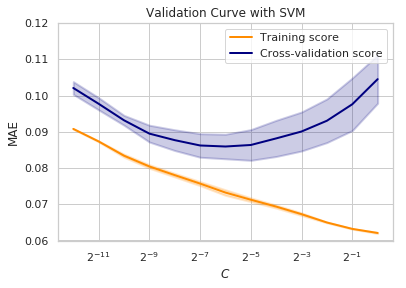

In [12]:
plt.title("Validation Curve with SVM")
plt.xlabel("$C$")
plt.ylabel("MAE")
plt.ylim(0.06, 0.12)
lw = 2
plt.semilogx(C_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw, basex=2)
plt.fill_between(C_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(C_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw, basex=2)
plt.fill_between(C_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Validation Curve (gamma)

In [13]:
from sklearn.model_selection import validation_curve

# Param gamma range.
gamma_range = np.logspace(-12, 0, 13, base=2)

# Cross-validation generator.
cv = cvPerYear(X, y, 2010, 2012, evalOnlyLast=False)

# Model.
model = SVR(**param_search.best_params_)
print(model)

train_scores, test_scores = validation_curve(
    model, Xt, y, param_name='gamma', 
    param_range=gamma_range, cv=cv,
    scoring='neg_mean_absolute_error', n_jobs=N_JOBS)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

SVR(C=0.015625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0078125, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)


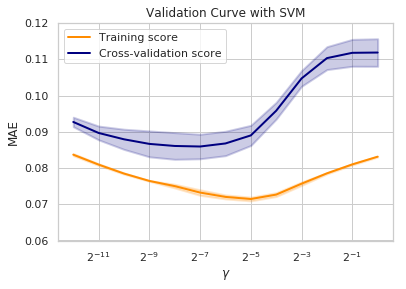

In [14]:
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("MAE")
plt.ylim(0.06, 0.12)
lw = 2
plt.semilogx(gamma_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw, basex=2)
plt.fill_between(gamma_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(gamma_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw, basex=2)
plt.fill_between(gamma_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Train on all data

In [86]:
# Exclude test data.
df_train = df_all_ftrs[~df_all_ftrs.production.isna()]

# All features.
features = list(set(df_train.columns) - set(['production', 'date', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Train.
model = SVR(**param_search.best_params_)
model.fit(Xt, y)

SVR(C=0.125, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0078125, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

### Submission and Description Files

It makes the predict of the basic model and creates the sample to substrate in kaggle, finishing the complete pipeline

In [87]:
from datetime import datetime

# Get test examples.
df_test = df_all_ftrs[df_all_ftrs.production.isna()]

# Important features.
X = df_test[features]

# Normalize input features.
Xt = scaler.transform(X)

# Make prediction.
pred = model.predict(Xt)

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')

submission_file  = '../submissions/{}.submission.csv'.format(now)
model_file       = '../submissions/{}.model.pkl'.format(now)
description_file = '../submissions/{}.params.json'.format(now)

# Create a submission file.
with open(submission_file, 'w') as f:
    f.write("Id,production\n")
    for _id, _pred in zip(df_test.Id.values, pred):
        f.write("{},{}\n".format(_id, _pred))

# Save model.
import pickle
with open(model_file, 'wb') as f:
    pickle.dump(model, f)

# Save model description.
import json
params = {
    'model': str(model),
    'best_params': param_search.best_params_,
    'model_val': json.loads(param_res[param_res.rank_test_score == 1].squeeze().to_json())
}
with open(description_file, 'w') as f:
    json.dump(params, f, indent=2)